# Case Técnico Fácil Espaider: Classificação Multilabel de gêneros de filmes baseado em sinopse

## Planejamento da Solução

### Entrada

* Base de metadados de filmes com as característica de cada um dos filmes e seus respectivos gêneros atribuídos.
* Sinopse dos filmes com identificador usado para se referenciar a base de metadados dos filmes.
                        

### Saída

* Qual formato de entrega da solução?

    * 1 Jupyter Notebooks, onde o projeto foi desenvolvido por meio de ciclos, com objetivo de gerenciar e planejar os próximos passos.
    * 2 O modelo está em produção através de uma API criada e hospedada no WebService do Render. As previsões geradas por esse modelo podem ser acessadas por meio de um BOT no Telegram (https://t.me/genrespred_bot). Para utilizar o BOT, basta inserir a sinopse de um filme como entrada e, em seguida, será realizada uma consulta à API do modelo para retornar os gêneros correspondentes à sinopse digitada.

<font size ="2" > PS: *É importante observar que o Telegram tem um limite máximo de 4096 caracteres para cada mensagem enviada. Se a sinopse de um filme ultrapassar esse limite, ela será dividida em duas ou mais mensagens. Nesse caso, o modelo fará uma nova previsão para cada uma dessas partes da mensagem. Portanto, caso queira testar uma sinopse com tamanho maior que 4096 caracteres, estarei disponibilizando uma função ao fim do código para esse teste.* </font>


    


Metodologia
* CRISP-DS, metodologia ágil para desenvolvimento de projetos de ciência de dados (método cíclico)
* Abordagem Classificação MultiLabel utilizando NLP


Ferraments Utilizadas
* Python 3.10.6, Jupyter-Lab, Poetry, Git, Github.

## Implementações realizadas na Sprint

### Ciclo 3 - Final

* Foram realizadas algumas técnicas de pré-processamento, como tokenização, stemming e n-gram.
* As features foram criadas utilizando TfIdf e outros parâmetros de controle.
* As features geradas foram normalizadas para melhor convergência do modelo.
* Foi implementado o Cross-Validation para avaliar melhor a performance do modelo.
* Testamos novos modelos e ajustamos alguns parâmetros, como o balanceamento das classes definido dentro dos parâmetros de cada modelo (class_weight='balanced').
* Realizamos a Hyper-Parametrização de alguns modelos selecionados.
* Geramos o modelo final para produção.
* Ajustamos a função de predição de gêneros de filme.
* Modelo em produção por meio de uma API.
* Criação de um BOT no telegram que consulta a API do modelo e retorna o gênero.
* Implementação de uma função para testar nossa API.
* Conclusão e Trabalhos Futuros.



# 0.0 Imports and Helper Functions

In [248]:
import pandas as pd
import numpy as np
import csv
import json
import seaborn as sns
import unicodedata
import warnings
import pickle
import re

from tqdm import tqdm
from IPython.display import Image

from matplotlib import pyplot as plt
from IPython.core.display import HTML

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
#nltk.download('stopwords')
from nltk.corpus   import stopwords
from nltk.stem     import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
stop_words = set(stopwords.words('english'))

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MultiLabelBinarizer


from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,hamming_loss,jaccard_score,make_scorer

from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB


## 0.1 Auxiliar Functions

In [7]:
# Configuration of the jupyter-lab cells to better Visualization
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML ('<style>.container {width:100% !important;} </style>') )
    pd.options.display.max_columns=None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr',False)
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    
    sns.set()
    
jupyter_settings()

# Contraction to Full Word -> Contraction is a shortened form of a word that is create by combining two or more words together 
# Example: it's = it is | don't = do not
def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value=contractions[key]
            x=x.replace(key,value)
        return x
    else:
        return x

# Count the frequency of the words in our collection of documents -> Notice that is the absolute frequency not the TFIDF freq that we will use to build our NLP Model

def freq_words(x, terms = 50):
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split()
    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
    
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
    
# Remove some characters with accent: like á ã í ú and others.
def remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

# Remove some defined stopwords with NLTK package
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)


# Function to avaliate our perfomance models
# Our principal metrics will be: F1_SCORE, Jaccard_Score and Hamming Loss
def multilabel_metrics(model,y_true,y_pred):
   
    precision = precision_score(y_true,y_pred,average='weighted',zero_division=1)
    recall = recall_score(y_true,y_pred,average='weighted',zero_division=1)
    f1 = f1_score(y_true,y_pred,average='weighted',zero_division=1)
    hamming = hamming_loss(y_true,y_pred)
    jaccard = jaccard_score(y_true,y_pred,average='weighted',zero_division=1)
    
    
    model_name = model.__class__.__name__
    estimator_name = model.estimator.__class__.__name__
    full_name = '_'.join([model_name, estimator_name])
    
    return pd.DataFrame({'Model Name':full_name,
                         'precision': precision,
                         'recall': recall,
                         'f1_score': f1,
                         'hamming_loss': hamming,
                         'jaccard_score': jaccard},index=[0])


# Initialize stemmer and tokenizer
stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer(r'\w+')

# Function that tokenize and stemm our bag of words
def tokenize_and_stem(text):
    # Tokenize the text into individual words
    tokens = tokenizer.tokenize(text.lower())
    
    # Apply the Snowball stemmer to each word
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    
    return stemmed_tokens

# Function that we call to make all the data processing and cleaning to our bag of words
def clean_text(text):
    
    # Remove Url
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    
    #Remove tudo entre tag <ref }
    text = re.sub(r'<ref.*?}}', '', text)
    
    # lower case
    text = text.lower()
    
    # Remove Contraction and transform into full word
    text = cont_to_exp(text)
    
    # Remove Special Chars or punctuation
    text = re.sub('[^A-Z a-z 0-9-]+', '',text)
    
    # Removed Accented Chars
    text = remove_accented_chars(text)
    
    # Remove Stopwords
    text = remove_stopwords(text)
    
    # Remove all non alphabeticall
    text = re.sub('[^a-zA-Z]',' ',text)
    
    # Removed duplicated spaces
    text = " ".join(text.split())
    
    # Remove numbers in form of text
    text = re.sub(r'\b(zero|one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|eighty|ninety|hundred)\b', '', text)
    
    return text

# Function to make predicition based on a synopsis inputed by the user.
def predict_genres(model,text):
    text = clean_text(text)
    text_vec = tfidf.transform([text])
    text_vec = normalizer.transform(text_vec)
    text_pred = model.predict(text_vec)
    
    return multilabel_.inverse_transform(text_pred)


# 1.0 Data Description

## 1.1 Leitura Dados dos Filmes

In [8]:
df1 = pd.read_csv("../data/movie.metadata.tsv", sep = '\t', header = None)

### 1.1.1 Rename Columns

Dataset without column identification, so let's name the ones that interest us

In [9]:
df1.columns = ['id_filme','col_2', 'nome_filme', 'cod_3', 'cod_4', 'cod_5', 'cod_6','cod_7','genero_filme']

## 1.2 Leitura Dados de Entrada ( Sinopses dos Filmes em formato txt)

In [10]:
sinopse = []

with open("../data/plot_summaries.txt", 'r') as file:
    texto = csv.reader(file,dialect='excel-tab')
    
    for row in tqdm(texto):
        sinopse.append(row)

42303it [00:00, 75363.64it/s]


So let's take a look at how the synopses are organized.

In [11]:
sinopse[:1]

[['23890098',
  "Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."]]

Here, we have the movie ID and synopsis, which we will use the ID as a reference to the movie dataset and its corresponding genre.

Next step:
* Extract the ID and synopsis from each element in the list and add them to a DataFrame.

In [12]:
id_filme = []
sinopse_filme = []

In [13]:
for i in tqdm(sinopse):
    id_filme.append(i[0])
    sinopse_filme.append(i[1])
    
# Build the DataFrame 
df_sinopse = pd.DataFrame({'id_filme':id_filme, 'sinopse_filme': sinopse_filme})

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42303/42303 [00:00<00:00, 2434806.34it/s]


In [14]:
df_sinopse.head()

,id_filme,sinopse_filme
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


Check duplicated on both dataframes

In [15]:
df1.duplicated().sum()

0

In [16]:
df_sinopse.duplicated().sum()

0

## 1.3 Data Types

In [17]:
df1.dtypes

id_filme          int64
col_2            object
nome_filme       object
cod_3            object
cod_4           float64
cod_5           float64
cod_6            object
cod_7            object
genero_filme     object
dtype: object

In [18]:
df_sinopse.dtypes

id_filme         object
sinopse_filme    object
dtype: object

We will change the movie id to string, so we can join both dataframes

In [19]:
df1['id_filme'] = df1['id_filme'].astype(str)

## 1.4 Data Dimension

In [20]:
df1.shape

(81741, 9)

In [21]:
df_sinopse.shape

(42303, 2)

In [22]:
print('So we have in your metadata of movies: {} with {} columns.'.format(df1.shape[0],df1.shape[1]))
print('In the sinopses dataframe we have only {} films with sinopses defined'.format(df_sinopse.shape[0]))

So we have in your metadata of movies: 81741 with 9 columns.
In the sinopses dataframe we have only 42303 films with sinopses defined


Quick Check in duplicated id_filme and nome_filme

In [23]:
df1[['id_filme']].duplicated().sum()

0

In [26]:
x = df1[df1['nome_filme'].duplicated()]
x.sample(3)

,id_filme,col_2,nome_filme,cod_3,cod_4,cod_5,cod_6,cod_7,genero_filme
78124,2660232,/m/07w0bp,The Burmese Harp,1956-01-21,NaN,116.0000,"{""/m/03_9r"": ""Japanese Language"", ""/m/02h40lc""...","{""/m/03_3d"": ""Japan""}","{""/m/0gw5n2f"": ""Japanese Movies"", ""/m/03q4nz"":..."
59378,29082911,/m/093dsw8,Undertow,2009-09-23,NaN,102.0000,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0f8l9c"": ""France"", ""/m/01ls2"": ""Colombia""...","{""/m/0hn10"": ""LGBT"", ""/m/0604r_"": ""Fictional f..."
71021,27289192,/m/0by0960,Lilies of the Field,1934,NaN,75.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02l7c8"": ""Romance Film"", ""/m/01z4y"": ""Com..."


In [27]:
df1[df1['nome_filme'] == 'Undertow']

,id_filme,col_2,nome_filme,cod_3,cod_4,cod_5,cod_6,cod_7,genero_filme
18723,3025805,/m/08ldl8,Undertow,2004-10-22,143597.0000,108.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F..."
59378,29082911,/m/093dsw8,Undertow,2009-09-23,NaN,102.0000,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0f8l9c"": ""France"", ""/m/01ls2"": ""Colombia""...","{""/m/0hn10"": ""LGBT"", ""/m/0604r_"": ""Fictional f..."
64064,20475330,/m/04_074f,Undertow,1949-12-01,NaN,71.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/01g6gs"": ""Black-..."


We made a quick check and noticed that there are movies with the same name but their represent different genders, so we will keep them for now (should check later if they had the same sinopse)

## 1.5 Join Datasets

So we can analyze a little bit better we should join the sinopse with the metadata of the movies 

In [28]:
df_final = pd.merge(df1,df_sinopse,on='id_filme',how='left')

## 1.6 Check and Drop NA

In [29]:
df_final.isna().sum()

id_filme             0
col_2                0
nome_filme           0
cod_3             6902
cod_4            73340
cod_5            20450
cod_6                0
cod_7                0
genero_filme         0
sinopse_filme    39537
dtype: int64

There are 39537 movies without sinopses, so we should drop them in then next section and use only the filmes with sinopse and genre to create our model

In [30]:
df_final.shape

(81741, 10)

# 2.0 Data Filtering

In [58]:
df2 = df_final.copy()

## 2.1 Select Columns

In [59]:
# We will we keep the necessary variables that will be used for the development of the project
df2 = df2[['id_filme','nome_filme','genero_filme','sinopse_filme']].copy()

## 2.2 Selecting only The Genders

In [60]:
df2['genero_filme'][0]

'{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}'

- The column is described as a string in the DataFrame, so first we need to transform it into a dictionary and then extract the values of each key.
- It is possible to notice that the keys that start with "/m/" are actually the codes corresponding to each genre of our dataset.

Let's then extract only the key values that are the genres corresponding to that specific movie.

In [61]:
json.loads(df2['genero_filme'][0]).values()

dict_values(['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western'])

In [62]:
df2.head()

,id_filme,nome_filme,genero_filme,sinopse_filme
0,975900,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,Brun bitter,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,A Woman in Flames,"{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


In [63]:
# Extract all genres
generos = []

for i in df2['genero_filme']:
    generos.append(list(json.loads(i).values()))

In [64]:
df2['genero_filme'] = generos

In [65]:
df2.isna().sum()

id_filme             0
nome_filme           0
genero_filme         0
sinopse_filme    39537
dtype: int64

As we have 39537 films without a synopsis, we will not use them in our model.

In [66]:
df2 = df2.dropna()

In [67]:
# Drop lines without gender classification
df2_new = df2[~(df2['genero_filme'].str.len() == 0 )]

In [68]:
df2.shape, df2_new.shape

((42204, 4), (41793, 4))

In [69]:
removed = df2.shape[0] - df2_new.shape[0]
print('There were {} films without genre classification that were removed.'.format(removed))

There were 411 films without genre classification that were removed.


## Converting the Genres to labels

In traditional classification problems, a single instance is typically associated with only one class, whereas in multi-label classification problems, a single instance can have multiple labels. Therefore, we plan to use the MultiLabelBinarizer approach in our project, which involves transforming a set of labels into a binary set, with each label represented by a binary column. By using the MultiLabelBinarizer, we hope to effectively solve our multi-label classification problem.

In [70]:
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(df2_new['genero_filme'])
pickle.dump(multilabel,open('/home/jordanmalheiros/Estudismo/desafio_espaider/transformations/multilabel_transformation.pkl','wb'))


In [71]:
# multilabel_ = pickle.load(open('/home/jordanmalheiros/Estudismo/desafio_espaider/transformations/multilabel_transformation.pkl','rb'))

In [72]:
y.shape

(41793, 363)

So we have 363 different genres, lets take a quick look at them

In [73]:
# multilabel.classes_

In [74]:
x = pd.DataFrame(y,columns=multilabel.classes_)

In [75]:
x.columns

Index(['Absurdism', 'Acid western', 'Action', 'Action Comedy',
       'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult',
       'Adventure', 'Adventure Comedy',
       ...
       'Werewolf fiction', 'Western', 'Whodunit', 'Women in prison films',
       'Workplace Comedy', 'World History', 'World cinema', 'Wuxia', 'Z movie',
       'Zombie Film'],
      dtype='object', length=363)

# 3.0 Exploration Data Analysis

In [85]:
df4 = df2_new.copy()

## 3.1 Variable Response - Genres

Let's check first, how the movie genres are distributed in the dataset

In [86]:
df4.head()

,id_filme,nome_filme,genero_filme,sinopse_filme
0,975900,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
3,9363483,White Of The Eye,"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
4,261236,A Woman in Flames,[Drama],"Eva, an upper class housewife, becomes frustra..."
6,18998739,The Sorcerer's Apprentice,"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
12,6631279,Little city,"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."


In [87]:
todos_generos = sum(generos,[])
len(set(todos_generos))

363

As we saw in the previous section that are 363 unique genres in our dataset.


Here we will calculate the distribution of the genres troughout our dataset and make some analysis.

In [88]:
todos_generos = nltk.FreqDist(todos_generos) 
todos_generos = pd.DataFrame({'Genero': list(todos_generos.keys()),
                            'Count': list(todos_generos.values())})

In [89]:
todos_generos.sort_values('Count',ascending=False).head(5)

,Genero,Count
9,Drama,34007
18,Comedy,16349
29,Romance Film,10234
17,Black-and-white,9094
5,Action,8798


### 3.1.1 Frequency Genres Plot

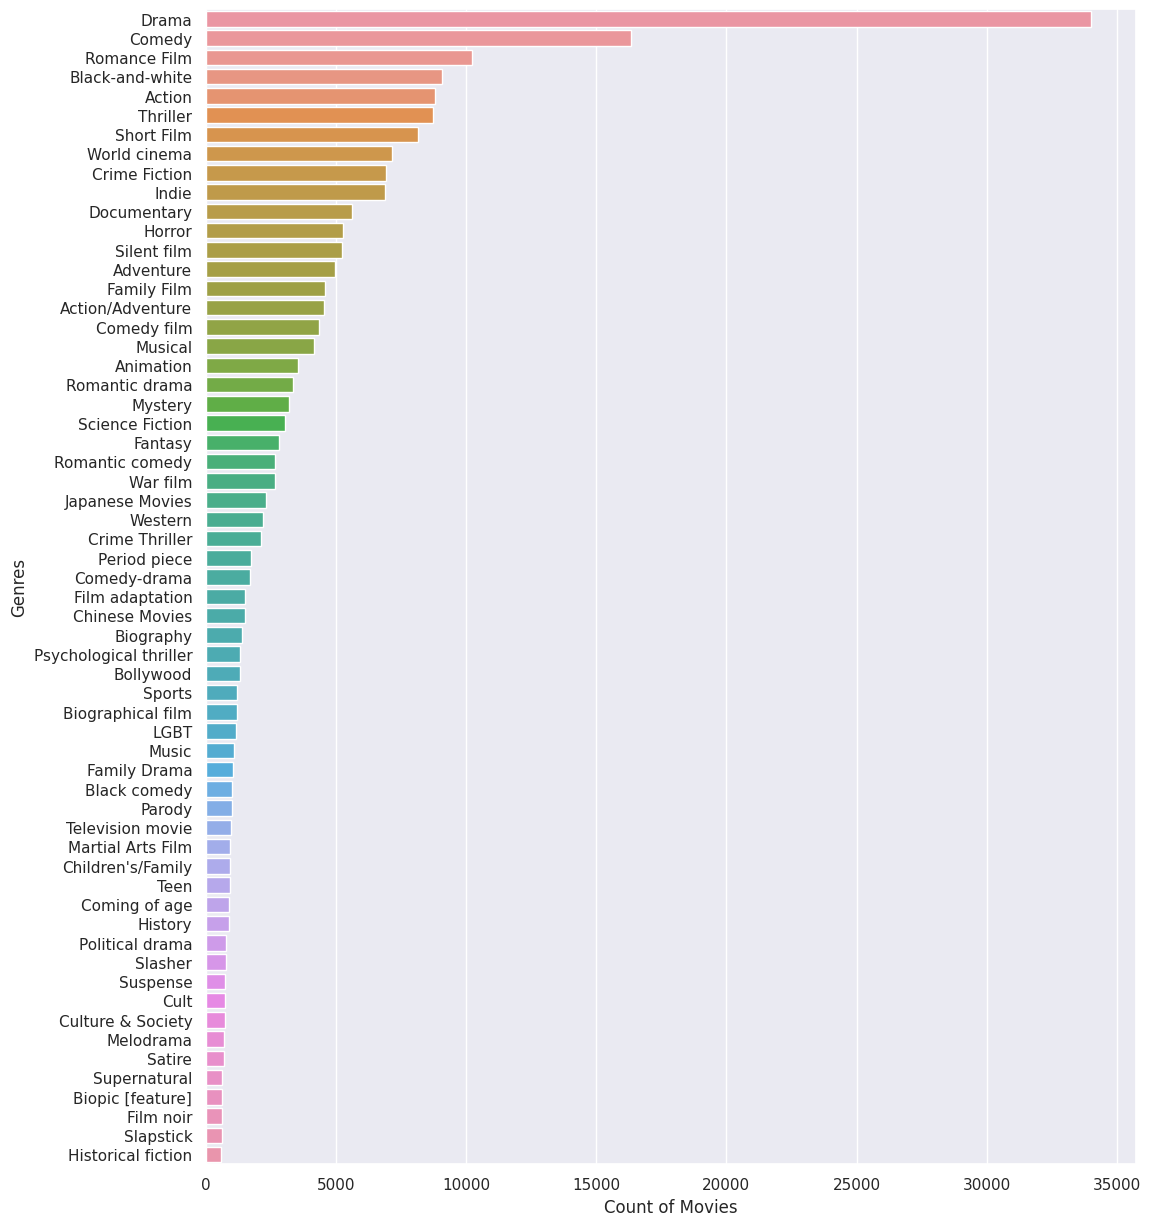

In [117]:
# Plot the top genders of movies
plot = todos_generos.nlargest(columns='Count',n=60)
plt.figure(figsize=(12,15))
ax = sns.barplot(data=plot, x= 'Count', y='Genero')
ax.set(xlabel = 'Count of Movies')
ax.set(ylabel = 'Genres')
plt.show()

### 3.1.2 Distribution in percentage of classes

In [118]:
todos_generos['percentage(%)'] = todos_generos['Count'] / todos_generos['Count'].sum() * 100

In [119]:
todos_generos.sort_values('Count',ascending=False).head(10).reset_index(drop=True)

,Genero,Count,percentage(%)
0,Drama,34007,13.9757
1,Comedy,16349,6.7189
2,Romance Film,10234,4.2058
3,Black-and-white,9094,3.7373
4,Action,8798,3.6157
5,Thriller,8744,3.5935
6,Short Film,8141,3.3457
7,World cinema,7155,2.9405
8,Crime Fiction,6948,2.8554
9,Indie,6897,2.8344


Based on this dataframe, it can be observed that there are significantly more movies classified as "Drama" than any other genre in our dataset, which leads to class imbalance. This factor should be considered while proceeding with the project and exploring methods to compensate for this issue.

### 3.1.3 WordCloud Genres Analysis

In [120]:
df4.head()

,id_filme,nome_filme,genero_filme,sinopse_filme
0,975900,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
3,9363483,White Of The Eye,"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
4,261236,A Woman in Flames,[Drama],"Eva, an upper class housewife, becomes frustra..."
6,18998739,The Sorcerer's Apprentice,"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
12,6631279,Little city,"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."


In [121]:
df_aux = df4.copy()
# Transform genres from list to string so we can add them into a wordcloud
df_aux['genero_filme'] = df_aux['genero_filme'].apply(lambda x: ','.join(x))

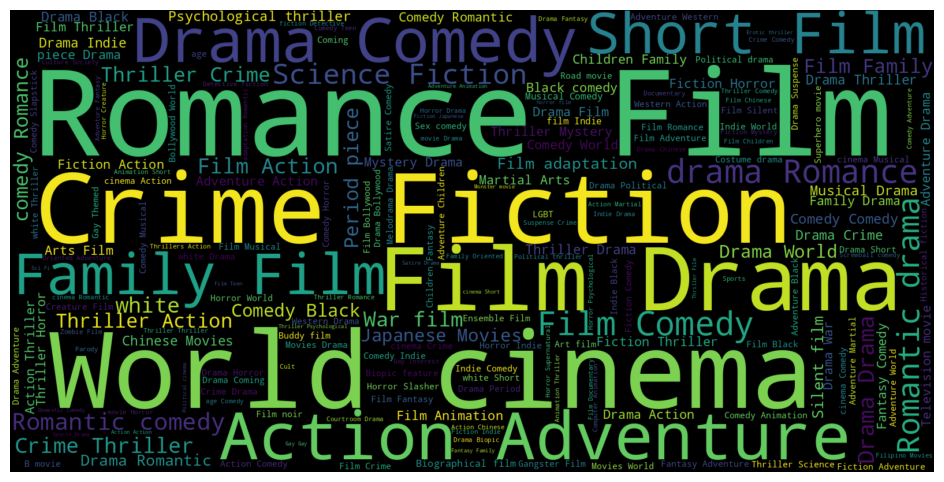

In [122]:
text = " ".join(i for i in df_aux['genero_filme'])
stopwords = set(STOPWORDS)
stopwords.update([',','.'])
wordcloud = WordCloud(stopwords=stopwords,background_color='black',width=1600,height=800).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


* This is a wordcloud. A wordcloud is a representation of text data which the size of each words indicates its frequency or importance within a give corpus of text. So here we use them to check quickly what are most common genres on our dataset.

## 3.2 Variable Text - Sinopse

### 3.2.1 Number of Genders per Sinopse

In [123]:
df_aux['number_generos'] = df_aux['genero_filme'].apply(lambda x: len(x.split(',')))

In [124]:
df_aux.head()

,id_filme,nome_filme,genero_filme,sinopse_filme,number_generos
0,975900,Ghosts of Mars,"Thriller,Science Fiction,Horror,Adventure,Supe...","Set in the second half of the 22nd century, th...",7
3,9363483,White Of The Eye,"Thriller,Erotic thriller,Psychological thriller",A series of murders of rich young women throug...,3
4,261236,A Woman in Flames,Drama,"Eva, an upper class housewife, becomes frustra...",1
6,18998739,The Sorcerer's Apprentice,"Family Film,Fantasy,Adventure,World cinema","Every hundred years, the evil Morgana returns...",4
12,6631279,Little city,"Romantic comedy,Ensemble Film,Comedy-drama,Dra...","Adam, a San Francisco-based artist who works a...",7


In [125]:
print('Max number of genres per synopsis: {}'.format(max(df_aux['number_generos'])))
print('Min number of genres per synopsis: {}'.format(min(df_aux['number_generos'])))
print('Average number of genres per synopsis: {:.2f}'.format(sum(df_aux['number_generos']) / len(df_aux['number_generos'])))

Max number of genres per synopsis: 17
Min number of genres per synopsis: 1
Average number of genres per synopsis: 3.61


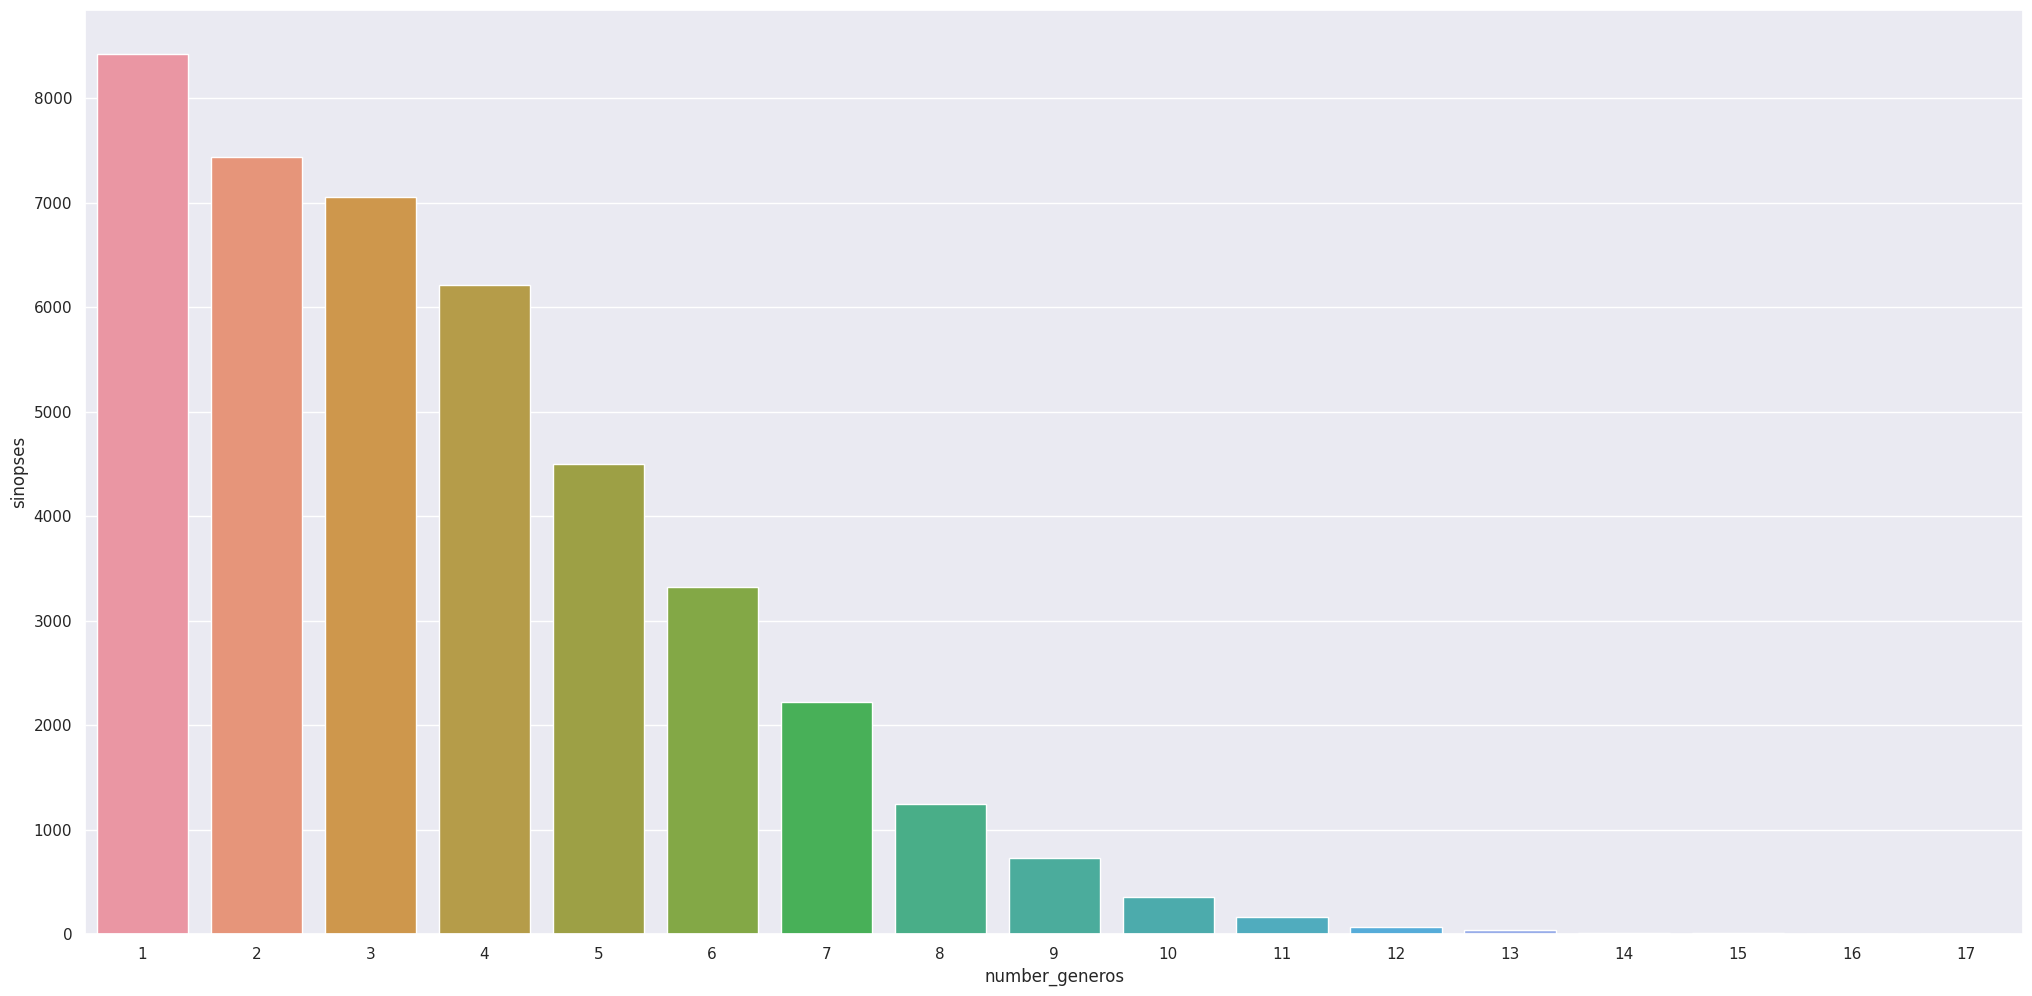

In [126]:
df_aux_2 = df_aux[['id_filme','number_generos']].groupby('number_generos').count().reset_index().rename(columns={'id_filme':'sinopses'})
df_aux_2 = df_aux_2.sort_values('sinopses',ascending=False)
sns.barplot(x='number_generos',y='sinopses',data=df_aux_2);


### 3.2.2 Words Checking the Sinopse Words Distribution

In [127]:
df4['sinopse_filme'].head(10)

0     Set in the second half of the 22nd century, th...
3     A series of murders of rich young women throug...
4     Eva, an upper class housewife, becomes frustra...
6     Every hundred years, the evil Morgana  returns...
12    Adam, a San Francisco-based artist who works a...
13    {{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
14    Serap, a young actress with a strong, lively p...
15     The story starts as one of the robots flies i...
17    The film opens with Mary Poppins  perched in a...
22    Jimmy ([[Hiroshi Watanabe  loves dinosaurs and...
Name: sinopse_filme, dtype: object

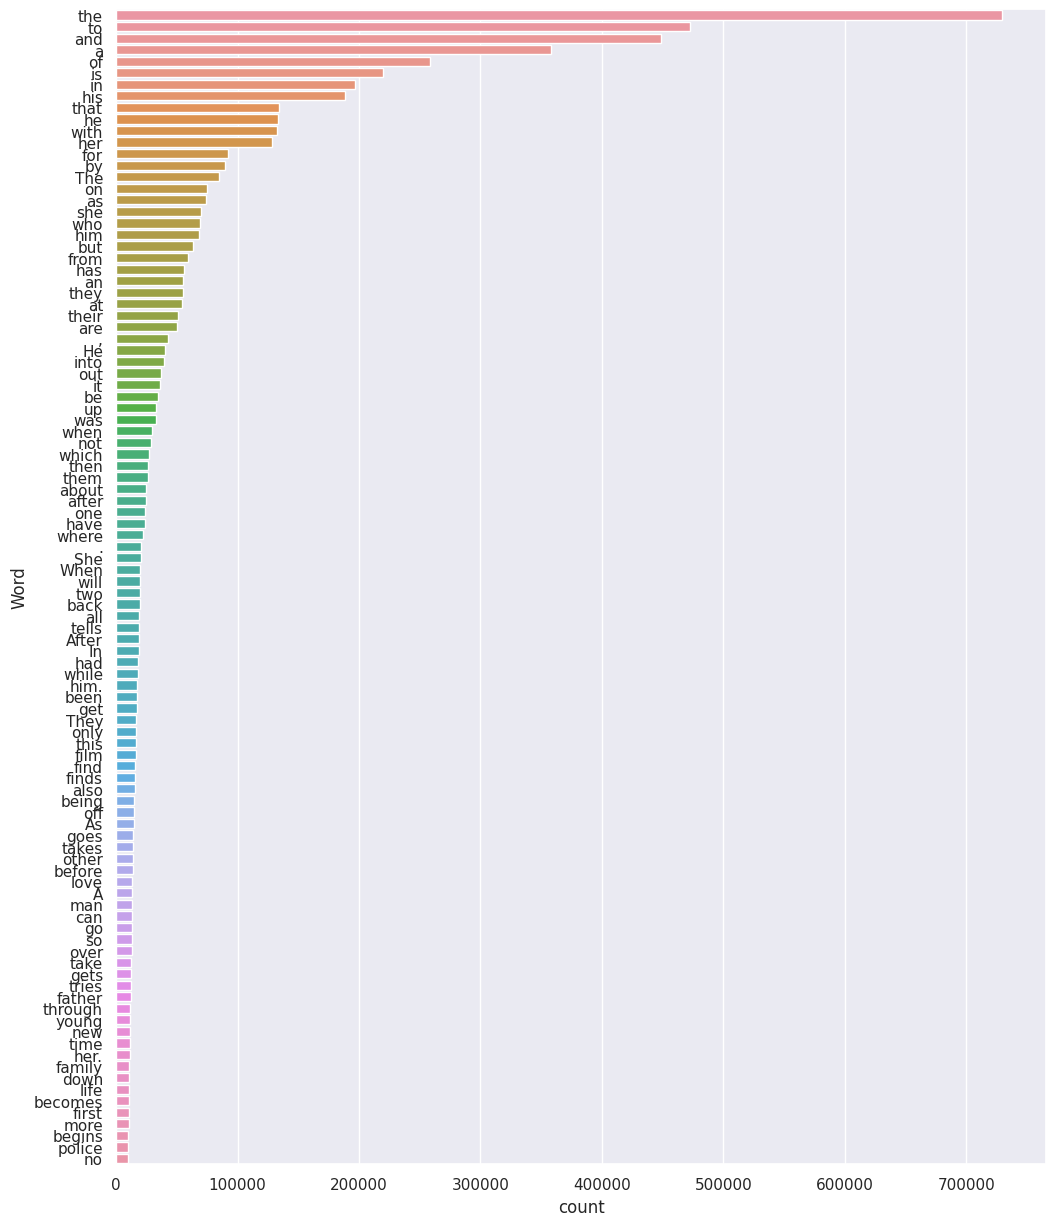

In [128]:
# print 100 most frequent words 
freq_words(df4['sinopse_filme'], 100)

As shown in the charts above, a large portion of the terms are identified as stopwords. Stopwords are typically common words in a language that are frequently removed from texts before they are processed for tasks such as natural language processing, text classification or information retrieval.

Since stopwords are less informative than other keywords present in the texts, they can add unnecessary noise to our model. In the next section, we will use some preprocessing techniques to clean up our data.

# 4.0 Data Preparation - PreProcessing and Cleaning

In [129]:
df5 = df4.copy()

Pre-Processing Cleaning Process applied:
* Lower Case
* Remove Contraction to Expansion
* Removal of Special Chars
* Removal of Accented Chars
* Removal of duplicated empty spaces
* Removal of stopwords


In [130]:
with open('../data/contractions.txt') as file:
    data = file.read()

contractions = json.loads(data)

# Cleaning Sinopse Text
df5['sinopse_filme'] = df5['sinopse_filme'].apply(lambda x: clean_text(x))


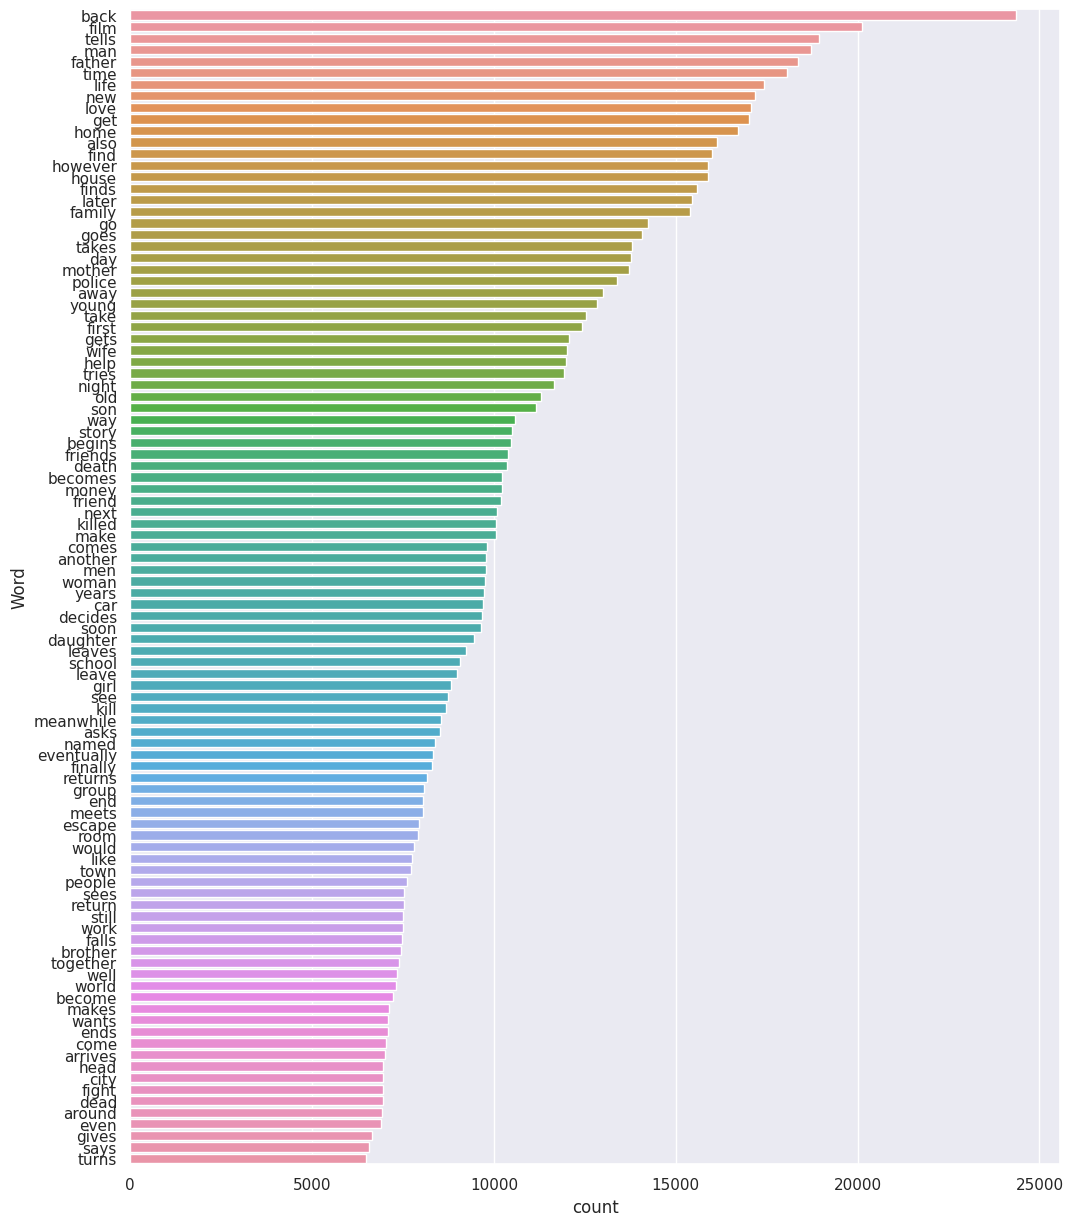

In [131]:
freq_words(df5['sinopse_filme'], 100)

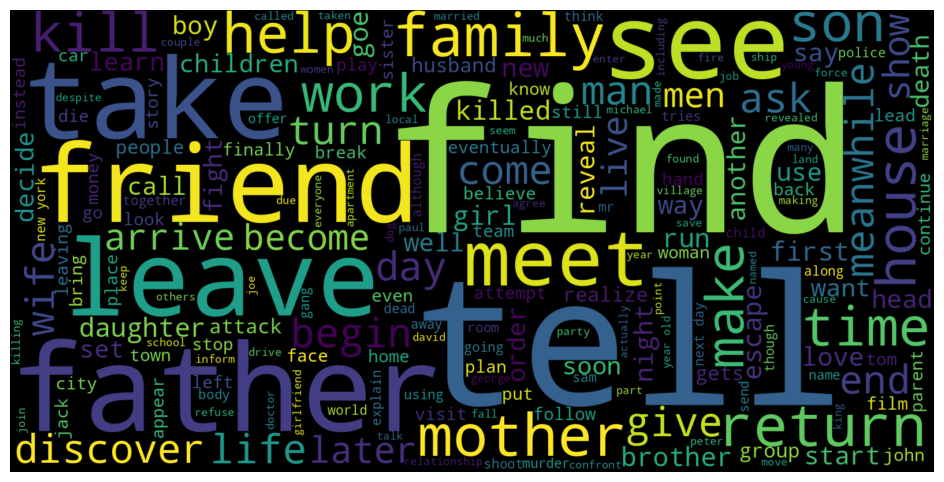

In [115]:
df_aux = df5.copy()

text = " ".join(i for i in df_aux['sinopse_filme'])
stopwords = set(STOPWORDS)
stopwords.update([',','.'])
wordcloud = WordCloud(stopwords=stopwords,background_color='black',width=1600,height=800).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


* Wordcloud for the most common words in our Synopsis Text after cleaning

# 5.0 Feature Creation

We will be focusing on the TF-IDF technique in this project to convert our train and test dataset into numerical vectors.

* The TF-IDF technique is a widely used text mining approach that aims to measure the relevance of a term in a document or corpus.
* It stands for Term Frequency-Inverse Document Frequency and consists of two parts: the term frequency (TF), which measures how frequently a term appears in a document, and the inverse document frequency (IDF), which measures how important a term is across the entire corpus.
* The TF-IDF score is the product of these two measures, where a high score indicates that a term is both frequent in a document and rare across the corpus, making it more relevant to the document

In [145]:
#nltk.download('punkt')

In [146]:
df6 = df5.copy()

In [147]:
df6.head()

,id_filme,nome_filme,genero_filme,sinopse_filme
0,975900,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,...",set second half nd century film depicts mars p...
3,9363483,White Of The Eye,"[Thriller, Erotic thriller, Psychological thri...",series murders rich young women throughout ari...
4,261236,A Woman in Flames,[Drama],eva upper class housewife becomes frustrated l...
6,18998739,The Sorcerer's Apprentice,"[Family Film, Fantasy, Adventure, World cinema]",every years evil morgana returns claim fingal...
12,6631279,Little city,"[Romantic comedy, Ensemble Film, Comedy-drama,...",adam san francisco based artist works cab driv...


## 5.1 Split Train and Test Dataset

In [148]:
x_train, x_validation, y_train, y_validation = train_test_split(df6['sinopse_filme'], y, test_size=0.2, random_state=42)

## 5.2 Create the TfidfVectorizer Model

Here, we will adjust some parameters for our model. Let's define each of them:

* max_features: this is the maximum number of words that the TfIdfVectorizer will use as features.
* max_df and min_df: these parameters are used to remove words that appear too frequently (max_df) or too infrequently (min_df).
* ngram_range: this parameter determines the type of n-gram we will use. We will explain about n-grams further below.
* tokenizer: this is the function used to tokenize our words. In this project, we created a function that both tokenizes and stems our words.

After conducting some tests, we determined the following parameters for the TfidfVectorizer:
- max_features: 20.000, which means that our model will have a maximum of 20,000 words selected as features.
- max_df: 0.85, which means that words appearing in 85% of the synopses will be removed as features.
- min_df: 3, which means that words appearing in less than 3 synopses will be removed as features.
- tokenizer: we used a specific function for tokenizing and stemming the words.
- n_gram_range: we chose to use 1-gram, 2-gram, and 3-gram.

An n-gram is a contiguous sequence of words extracted from a text corpus. When using the TF-IDF approach, n-grams can be used to capture the context of the text and improve the performance of our model. For example, in a bag-of-words model, the context of a word is lost and each word is treated independently. However, using n-grams allows us to capture some of the context around the word and preserve some of the meaning that would otherwise be lost.

In [149]:
# Create the Matrix of tdidf frequency of words
tfidf = TfidfVectorizer(analyzer='word',max_features=20000,max_df=0.85,min_df=3,ngram_range=(1, 3),tokenizer=tokenize_and_stem)
X = tfidf.fit_transform(df6['sinopse_filme'])
# pickle.dump(tfidf,open('/home/jordanmalheiros/Estudismo/desafio_espaider/transformations/tfidf_transformation.pkl','wb'))


/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [150]:
X

<41793x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 5090379 stored elements in Compressed Sparse Row format>

Here we can see that the TfidfVectorizer selected a total of 20.000 words as features, now lets take a quick look at them

In [151]:
tfidf.get_feature_names_out()

array(['a', 'a lot', 'aakash', ..., 'zorba', 'zorro', 'zulu'],
      dtype=object)

In [152]:
len(tfidf.get_feature_names_out())

20000

## 5.2 Apply Normalization and Tfidf Transformation do dataset

We create a sparse matrix when using the TfidfVectorizer because the vectorizer produces a high-dimensional feature space that can be very large, and most of the values in the matrix are zeros.

Normalizing a sparse matrix that was created using the TfidfVectorizer can be a good idea for several reasons:

- Makes the data more comparable across features by defining the values in a fixed range. This can be useful when we want to compare the importance of different words in the text. For example, if one word has a much higher TF-IDF score than another, we might assume that it's more important. But if the scores are normalized, we can compare them more easily.

* Can improve the performance of certain algorithms. Some algorithms are sensitive to the scale of the data, and normalization can help to make the data more consistent and easier to analyze. For example, clustering algorithms can benefit from normalization because it can help to make the clusters more distinct.

* Can help to reduce the effect of outliers in the data. Sparse matrices can have many zeros and a few non-zero entries that are very high. These extreme values can skew our analysis and make it difficult to identify patterns. Normalization can help to reduce the impact of these extreme values and make the data more robust.

In [153]:
normalizer = Normalizer()
pickle.dump(normalizer,open('/home/jordanmalheiros/Estudismo/desafio_espaider/transformations/norm_transformation.pkl','wb'))

x_train = tfidf.transform(x_train)
x_train = normalizer.fit_transform(x_train)

x_validation = tfidf.transform(x_validation)
x_validation = normalizer.transform(x_validation)


# 6.0 Model Testing

Here, as our go-to Metric we will be using:

F1_Score: metric for multilabel classification, and it calculates the harmonic mean of precision and recall for each label. PS:Notice that we will be using average='weighted', where the f1_score takes into account the number of samples in each label, providing a more meaningful measure of overall performance when the distribution of labels is imbalanced.

Hamming_loss: metric that calculates the proportion of samples that are incorrectly labeled.
Jaccard_score: metric that measures the similarity between two set os labels, for multilabel classification, it calculates the ratio of the number of correctly predicted labels to the number of total predicted and true labels. This metric is very useful when the number of labels are large (our case).

Here, we will be using the following metrics to evaluate our model in multilabel classification:

- F1_Score: It calculates the harmonic mean of precision and recall for each label and provides a more meaningful measure of overall performance when the distribution of labels are imbalanced. We will be using average='weighted', which takes into account the number of samples in each label.
- Hamming_loss: It calculates the proportion of samples that are incorrectly labeled. The lower the better the model is.
- Jaccard_score: It measures the similarity between two sets of labels, for multilabel classification it calculates the ratio of the number of correctly predicted labels to the number of total predicted and true labels. This metric is very useful when the number of labels is large, as in our case (more than 300 labels), we will be using it as well. The highest the better our model is.

In [154]:
# Define some metrics
scoring = {'precision': make_scorer(precision_score, average='weighted',zero_division=1),
           'recall': make_scorer(recall_score, average='weighted',zero_division=1),
           'f1_score': make_scorer(f1_score, average='weighted',zero_division=1),
           'hamming_loss': make_scorer(hamming_loss),
           'jaccard_score': make_scorer(jaccard_score, average='weighted',zero_division=1)}

As our go-to Algorithm we will be using the **OneVsRestClassifier** because it can handle multiple labels and can be applied to any classifier that can work with binary outcomes. In other words, this type of Classifier can transform a multilabel problem into multiple binary classification problems, where each label is treated as a separate binary classification problem. 

So this allow us to use any binary classifier as a base estimator, such as gradient boosting, logistic regresio, support vector machines and some others. 

## 6.1 SGD - Stochastic Gradient Boost

Let's test first using the validation and later on the cross_validation method since our Model is High Dimensional

In [155]:
sgd = SGDClassifier(class_weight='balanced',max_iter=2000)
clf_sgd = OneVsRestClassifier(sgd,n_jobs=-1)

clf_sgd.fit(x_train,y_train)
y_pred = clf_sgd.predict(x_validation)

print('OneVsRestaClassifier: Estimator SGD')
val_sgd = multilabel_metrics(clf_sgd,y_validation,y_pred)



/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 66 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 202 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 214 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Con

OneVsRestaClassifier: Estimator SGD


In [156]:
val_sgd

,Model Name,precision,recall,f1_score,hamming_loss,jaccard_score
0,OneVsRestClassifier_SGDClassifier,0.3552,0.6122,0.4395,0.0316,0.3008


Cross-Validation Score 

In [157]:
scores = cross_validate(clf_sgd,x_train,y_train,cv=5,scoring=scoring)

mean_scores = {}
for metric in scoring:
    mean_scores[metric] = np.mean(scores['test_' + metric])
    
sgd_cv = pd.DataFrame(mean_scores,index=[0])


/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 66 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 74 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 88 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 118 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Es

## 6.2 LogisticRegression()

In [158]:
lr = LogisticRegression(class_weight='balanced',max_iter=200,solver='newton-cg',penalty='l2')
clf_lr = OneVsRestClassifier(estimator=lr,n_jobs=-1)

clf_lr.fit(x_train,y_train)
y_pred = clf_lr.predict(x_validation)

print('OneVsRestaClassifier: Estimator LogisticRegression')
val_lr = multilabel_metrics(clf_lr,y_validation,y_pred)



/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 66 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 202 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 214 is present in all training examples.
  warnings.warn(


OneVsRestaClassifier: Estimator LogisticRegression


In [159]:
val_lr

,Model Name,precision,recall,f1_score,hamming_loss,jaccard_score
0,OneVsRestClassifier_LogisticRegression,0.3758,0.5907,0.4480,0.0160,0.3074


Cross-Validation Score

In [160]:
scores = cross_validate(clf_lr,x_train,y_train,cv=5,scoring=scoring)

mean_scores = {}
for metric_2 in scoring:
    mean_scores[metric_2] = np.mean(scores['test_' + metric_2])
    
lr_cv = pd.DataFrame(mean_scores,index=[0])



/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 66 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 74 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 88 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 118 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Es

### 6.2.1 LogisticRegression with Threshold's

In [161]:
# y_pred_prob = clf_lr.predict_proba(x_validation)

# t = 0.6 # threshold value
# y_pred_new = (y_pred_prob >= t).astype(int)

# multilabel_metrics(clf_lr,y_validation,y_pred_new)

## 6.3 Linear SVC


In [162]:
svc = LinearSVC(class_weight='balanced')
clf_svc = OneVsRestClassifier(svc,n_jobs=-1)

clf_svc.fit(x_train,y_train)
y_pred = clf_svc.predict(x_validation)

print('OneVsRestaClassifier: Estimator SVC')
val_svc = multilabel_metrics(clf_svc,y_validation,y_pred)

/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 66 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 202 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 214 is present in all training examples.
  warnings.warn(


OneVsRestaClassifier: Estimator SVC


In [163]:
val_svc

,Model Name,precision,recall,f1_score,hamming_loss,jaccard_score
0,OneVsRestClassifier_LinearSVC,0.4174,0.4631,0.4226,0.0121,0.2864


Cross Validation 

In [164]:
scores = cross_validate(clf_svc,x_train,y_train,cv=5,scoring=scoring)

mean_scores = {}
for metric_3 in scoring:
    mean_scores[metric_3] = np.mean(scores['test_' + metric_3])
    
svc_cv = pd.DataFrame(mean_scores,index=[0])



/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 66 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 74 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 88 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 118 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Es

## 6.4 Naive Bayes

In [165]:
# Naive Bayes
nb = MultinomialNB()
clf_nb = OneVsRestClassifier(nb,n_jobs=-1)

clf_nb.fit(x_train,y_train)
y_pred = clf_nb.predict(x_validation)

print('OneVsRestaClassifier: Estimator NB')
val_nb = multilabel_metrics(clf_nb,y_validation,y_pred)

/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 66 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 202 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 214 is present in all training examples.
  warnings.warn(


OneVsRestaClassifier: Estimator NB


Cross-Validation

In [166]:
scores = cross_validate(clf_nb,x_train,y_train,cv=5,scoring=scoring)

mean_scores = {}
for metric_4 in scoring:
    mean_scores[metric_4] = np.mean(scores['test_' + metric_4])
    
nb_cv = pd.DataFrame(mean_scores,index=[0])



/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 66 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 88 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 74 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 118 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Es

## 6.5 Compare Perfomances 

As we observed in the cross-validation evaluation, there were several warnings due to the following reasons:

* The warning message indicates that certain genres appear only in a few documents. Therefore, when we divide the dataset into training and validation sets, some genres may not be present in the training data. This issue is more noticeable in cross-validation because we split the dataset into multiple folds, and train and evaluate each fold.

* Since we will combine all the training and validation data in the end, we will not address this warning message right now in this project.

### 6.5.1 Models Applied on Validation Dataset

In [171]:
results_validation = pd.concat([val_sgd, val_lr,val_svc,val_nb])

In [172]:
results_validation.sort_values('f1_score',ascending=False)

,Model Name,precision,recall,f1_score,hamming_loss,jaccard_score
0,OneVsRestClassifier_LogisticRegression,0.3758,0.5907,0.4480,0.0160,0.3074
0,OneVsRestClassifier_SGDClassifier,0.3552,0.6122,0.4395,0.0316,0.3008
0,OneVsRestClassifier_LinearSVC,0.4174,0.4631,0.4226,0.0121,0.2864
0,OneVsRestClassifier_MultinomialNB,0.8357,0.1315,0.1597,0.0092,0.1071


So for our Validation Set the best model was the OneVsRestClassifier with the estimator of **LogisticRegression** with: 
- f1_score: 0.4480
- jaccard_score: 0.3074

### 6.5.2 Cross-Validation

In [202]:
results_cv_= pd.concat([sgd_cv,lr_cv,svc_cv,nb_cv])

In [222]:
results_cv = results_cv.reset_index(drop=True)
name = {0: 'SGD', 1: 'LR', 2:'SVC', 3: 'NB'}
results_cv = results_cv.rename(index=name)
results_cv.sort_values('f1_score',ascending=False)

,precision,recall,f1_score,hamming_loss,jaccard_score
LR,0.3780,0.5682,0.4417,0.0152,0.3026
SGD,0.3592,0.5773,0.4334,0.0304,0.2960
SVC,0.4174,0.4400,0.4099,0.0118,0.2770
NB,0.8354,0.1203,0.1438,0.0093,0.0973


So for our cross-validation method the better models perfomed were:
- LogisticRegression
- Stochastic Gradient Boost

So based on our testing and cv we will select the **LogisticRegression and LinearSVC** to Fine Tune our model

# 7.0 Fine Tuning

## 7.1 Logistic Regression Fine Tuning

In [223]:
import optuna

In [224]:
# def lr_objective(trial):
    
    
#     model = OneVsRestClassifier(LogisticRegression(class_weight='balanced',random_state=42,
#                                                    C = trial.suggest_float('C',1e-2,1),
#                                                    solver = trial.suggest_categorical('solver',['lbfgs','newton-cg','saga','sag']),
#                                                    tol = trial.suggest_float('tol',1e-6,1e-3)),n_jobs=-1).fit(x_train,y_train)
                
#     # Predict the Labels
#     yhat_lr = model.predict(x_validation)
    
#     # Metrics
#     f1_score_ = f1_score(y_validation,yhat_lr,average='weighted',zero_division=1)
    
#     return f1_score_

# study = optuna.create_study(direction='maximize')
# study.optimize(lr_objective,n_trials=100)

# trial = study.best_trial

# print('Best F1_score for LR: {}'.format(trial.value))
# print('Best hyperparam: {}'.format(trial.params))



In [225]:
# model = OneVsRestClassifier(LogisticRegression(class_weight='balanced',random_state=42),n_jobs=-1).fit(x_train,y_train)
# yhat_lr = model.predict(x_validation)

# f1_score_ = f1_score(y_validation,yhat_lr,average='weighted',zero_division=1)

In [226]:
# model = OneVsRestClassifier(LogisticRegression(class_weight='balanced',random_state=42,C=1.20,penalty='l2',solver='newton-cg',max_iter=1000,tol=1e-4),n_jobs=-1).fit(x_train,y_train)
# yhat_lr = model.predict(x_validation)

# f1_score_ = f1_score(y_validation,yhat_lr,average='weighted',zero_division=1)

## 7.2 SGD Fine Tuning

In [227]:
# import re
# import warnings

In [228]:
# from sklearn import metrics as m

In [ ]:
# def sgd_objective(trial):
    
#     model = OneVsRestClassifier(SGDClassifier(
#                                             # loss='hinge',
#                                             loss=trial.suggest_categorical('loss',['hinge','log_loss','modified_huber']),
#                                             # penalty='l2',
#                                             alpha=trial.suggest_float('alpha', 1e-4, 1e-1),
#                                             # l1_ratio=trial.suggest_float('l1_ratio', 0.0, 1.0),
#                                             max_iter=2000,
#                                             # tol=1e-3,
#                                             class_weight='balanced',
#                                             random_state=42),
#                               n_jobs=-1).fit(x_train,y_train)
    

#     yhat_sgd = model.predict(x_validation)
    
#     # Metrics
#     f1_score_ = m.f1_score(y_validation,yhat_sgd,average='weighted',zero_division=1)
    
#     return f1_score_

# study = optuna.create_study(direction='maximize')
# study.optimize(sgd_objective,n_trials=100)

# trial = study.best_trial

# print('Best F1_score for SGD: {}'.format(trial.value))
# print('Best hyperparam: {}'.format(trial.params))



Note that the hyper-parameter are commented because when we executed the optuna framework its created several cells with the scores and warning an to prevent the notebook to be to much crowded with not that useful information we omitted the execution.

After some tests: we reach out to the best perfomance of our model with the LogisticRegression estimator, with the followings parameters:
* c=1.20, 
* penalty='l2',
* solver='newton-cg'
* tol=1e-4

So based on this parameters and this model we will finally create our Final Model and test it on some synopse.

# 8.0 Final Model

## 8.1 Join Train and Validation Dataset

In [230]:
x_train_final = X
y_train_final = y

## 8.2 Final Model - LogisticRegression()

In [231]:
model = OneVsRestClassifier(LogisticRegression(class_weight='balanced',random_state=42,C=1.20,penalty='l2',solver='newton-cg',max_iter=1000,tol=1e-4),n_jobs=-1).fit(x_train_final,y_train_final)
model.fit(x_train_final,y_train_final)


OneVsRestClassifier(estimator=LogisticRegression(C=1.2, class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='newton-cg'),
                    n_jobs=-1)

In [74]:
# pickle.dump(model,open('/home/jordanmalheiros/Estudismo/desafio_espaider/model/model_lr_tuned.pkl','wb'))
# model_final = picke.load(

In [ ]:
model

# 9.0 Predict Movie Gender

In [75]:
print('Enter the sinopse:')
sinopse = input()
predict_genres(model,sinopse)

Enter the sinopse:


 In 1936, archaeologist Indiana Jones braves an ancient Peruvian temple filled with booby traps to retrieve a golden idol. Upon fleeing the temple, Indiana is confronted by rival archaeologist René Belloq and the indigenous Hovitos. Surrounded and outnumbered, Indiana is forced to surrender the idol to Belloq and escapes aboard a waiting Waco seaplane, in the process revealing his fear of snakes. Shortly after returning to the college in the United States where he teaches archaeology, Indiana is interviewed by two Army intelligence agents. They inform him that the Nazis, in their quest for occult power, are searching for his old mentor, Abner Ravenwood, who is the leading expert on the ancient Egyptian city of Tanis and possesses the headpiece of an artifact called the Staff of Ra. Indiana deduces that the Nazis are searching for Tanis because it is believed to be the location of the Ark of the Covenant, the biblical chest built by the Israelites to contain the fragments of the Ten Com

[('Action',
  'Action/Adventure',
  'Adventure',
  'Airplanes and airports',
  'Costume Adventure',
  'New Hollywood',
  'Science Fiction',
  'Thriller')]

# 10.0 Model to Production

* O modelo está em produção através de uma API criada e hospedada no WebService do Render. As previsões geradas por esse modelo podem ser acessadas por meio de um BOT no Telegram (https://t.me/jbm_genrespred_Bot).@ Para utilizar o BOT, basta inserir a sinopse de um filme como entrada e, em seguida, será realizada uma consulta à API do modelo para retornar os gêneros correspondentes à sinopse digitada.

<font size ="2" > PS: *É importante observar que o Telegram tem um limite máximo de 4096 caracteres para cada mensagem enviada. Se a sinopse de um filme ultrapassar esse limite, ela será dividida em duas ou mais mensagens. Nesse caso, o modelo fará uma nova previsão para cada uma dessas partes da mensagem. Portanto, caso queira testar uma sinopse com tamanho maior que 4096 caracteres, estarei disponibilizando uma função ao fim do código para esse teste.* </font>


A API do modelo está localizada no webservice: 
https://jbm-genrepred-deploy-og1d.onrender.com/, e pode ser acessada através do endpoint genres_pred/predict.

Os códigos das implementações dos notebooks, API do modelo e Bot do Telegram estão disponilizadas nos seguintes repositório do github:
- https://github.com/malheiros7j/bot-telegram-genrespred (Deploy Bot)
- https://github.com/jordanmalheirosdeploy?tab=repositories (Deploy API)
- [COLOCAR REPOSITORIO DOS NOTEBOOKS] (DEPLOY NOTEBOOKS)



## 10.1 API Model Deploy Code

### 10.1.1 Class

In [236]:
# import pickle
# import inflection
# import pandas as pd
# import numpy as np
# import math 
# import datetime
# import unicodedata
# import nltk
# import re
# import json

# import nltk
# nltk.download('stopwords', quiet=True)
# from nltk.corpus   import stopwords

# from nltk.stem     import SnowballStemmer
# from nltk.tokenize import RegexpTokenizer

# stop_words = set(stopwords.words('english'))

# stemmer = SnowballStemmer("english")
# tokenizer = RegexpTokenizer(r'\w+')


# class Genres_pred(object):

#     def __init__(self):

#         self.home_path = ''

#         # fitado
#         self.encoding_tfidf_vectorizer          = pickle.load(open(self.home_path + 'transformations/tfidf_transformation.pkl','rb'))

#         # sem fit
#         self.encoding_normalizer_transform      = pickle.load(open(self.home_path + 'transformations/norm_transformation.pkl','rb'))

#         # fitado
#         self.encoding_multilabel_transform      = pickle.load(open(self.home_path + 'transformations/multilabel_transformation.pkl','rb'))

#     def tokenize_and_stem(text):
#         # Tokenize the text into individual words
#         tokens = tokenizer.tokenize(text.lower())

#         # Apply the Snowball stemmer to each word
#         stemmed_tokens = [stemmer.stem(word) for word in tokens]

#         return stemmed_tokens

#     def remove_stopwords(self,text):
#         no_stopword_text = [w for w in text.split() if not w in stop_words]
#         return ' '.join(no_stopword_text)

#     def cont_to_exp(self,text):

#         with open('transformations/contractions.txt') as file:
#             data = file.read()
#         contractions = json.loads(data)

#         # print(contractions)

#         if type(text) is str:
#             for key in contractions:
#                 value=contractions[key]
#                 text=text.replace(key,value)
#             return text
#         else:
#             return text

#     def remove_accented_chars(self,text):
#         text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
#         return text

#     def clean_text(self,text):
#         # Remove Url
#         text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
        
#         #Remove tudo entre tag <ref }
#         text = re.sub(r'<ref.*?}}', '', text)
        
#         # lower case
#         text = text.lower()
        
#         # Remove Contraction and transform into full word
#         text = self.cont_to_exp(text)
        
#         # Remove Special Chars or punctuation
#         text = re.sub('[^A-Z a-z 0-9-]+', '',text)
        
#         # Removed Accented Chars
#         text = self.remove_accented_chars(text)
        
#         # Remove Stopwords
#         text = self.remove_stopwords(text)
        
#         # Remove all non alphabeticall
#         text = re.sub('[^a-zA-Z]',' ',text)
        
#         # Removed duplicated spaces
#         text = " ".join(text.split())
        
#         # Remove numbers in form of text
#         text = re.sub(r'\b(zero|one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|eighty|ninety|hundred)\b', '', text)
        
#         return text

#     def create_tfidf(self,text):
#         return self.encoding_tfidf_vectorizer.transform([text])
  

#     def normalize_feature(self,text):
#         return self.encoding_normalizer_transform.fit_transform(text)


#     def get_prediction(self,model,text):
#         text_pred = model.predict(text)
#         return self.encoding_multilabel_transform.inverse_transform(text_pred)


### 10.1.2 Handler.py

In [237]:
# from flask import Flask, request, Response, jsonify
# from genrespred.GenresPred import Genres_pred
# import pandas as pd
# import pickle
# import chardet
# import os

# import nltk
# nltk.download('stopwords', quiet=True)
# from nltk.corpus   import stopwords

# from nltk.stem     import SnowballStemmer
# from nltk.tokenize import RegexpTokenizer

# stemmer = SnowballStemmer("english")
# tokenizer = RegexpTokenizer(r'\w+')


# model = pickle.load(open('model/model_lr_tuned.pkl', 'rb'))

# def tokenize_and_stem(text):
#     # Tokenize the text into individual words
#     tokens = tokenizer.tokenize(text.lower())

#     # Apply the Snowball stemmer to each word
#     stemmed_tokens = [stemmer.stem(word) for word in tokens]

#     return stemmed_tokens

# # Initialize API
# app = Flask(__name__)

# @app.route('/genres_pred/predict', methods=['POST'])
# def genres_predict():

#     # test_string = request.data.decode('utf-8')
#     test_string = request.data.decode(chardet.detect(request.data)['encoding'])


#     if not isinstance(test_string, str):
#     	return jsonify({'error': 'Input data must be a string'}), 400

#     # Define Genres_pred function here or import it from somewhere else
#     pipeline = Genres_pred()

#     # Clean Text Synopsis
#     text = pipeline.clean_text(test_string)

#     # Transform into TFIDF
#     text_vec = pipeline.create_tfidf(text)


#     # Normalize the features created
#     text_vec = pipeline.normalize_feature(text_vec)


#     # Predict the genres
#     prediction = pipeline.get_prediction(model,text_vec)

#     return jsonify(prediction), 200

# if __name__ == '__main__':
#     port = os.environ.get('PORT',5000)
#     app.run(host='0.0.0.0',port=port)
    

## 10.2 BOT Telegram API Deploy Code

In [251]:
image_path = '../images/bot_.jpeg'

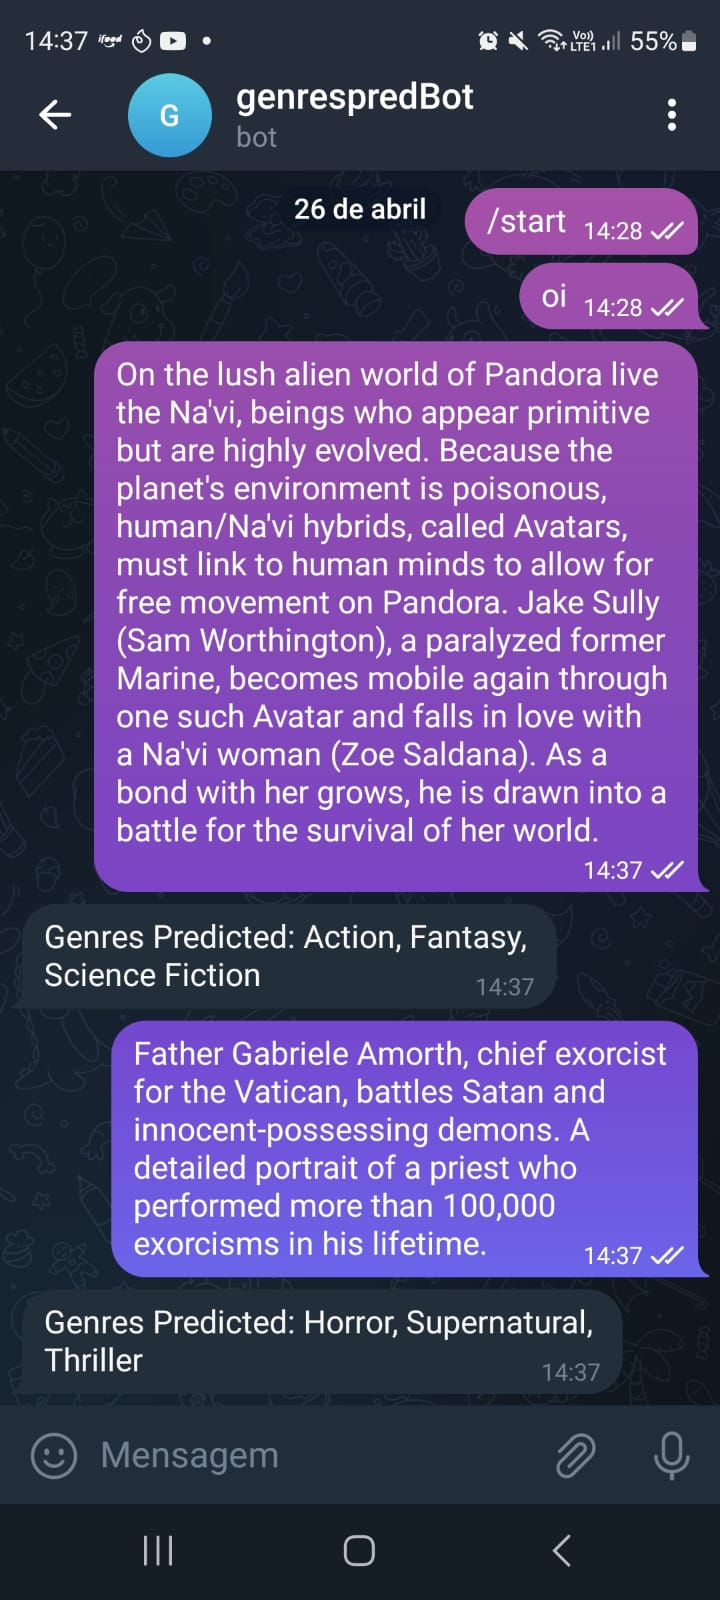

In [255]:
Image(filename=image_path, width=220, height=1100)

In [238]:
# import os
# import pandas as pd
# import json
# import requests
# from flask import Flask, request, Response

# # Constant
# token = '5935282467:AAHC--ZVIL0creRajCNxFfBFUQ92qxE-3e0'

# def send_message(chat_id,text):
# 	url = 'https://api.telegram.org/bot{}'.format(token)
# 	url = url + '/sendMessage?chat_id={}'.format(chat_id)

# 	r = requests.post(url,json={'text': text})

# 	print('Status Code {}'.format(r.status_code))

# 	return None

# def predict(data):

# 	# API CALL
# 	# Local API
# 	# url = 'http://127.0.0.1:5000/genres_pred/predict'
	
# 	# API in Production
# 	url = 'https://jbm-genrepred-deploy-og1d.onrender.com/genres_pred/predict'
	
# 	header = {'Content-type': 'text/plain'}
# 	data = data

# 	r = requests.post(url,data=data,headers=header)

# 	print('Status Code {}'.format(r.status_code))

# 	r_json = r.json()
# 	genres = r_json[0]
# 	genre_str = ", ".join(genres)

# 	return genre_str


# def parse_message(message):

# 	chat_id = message['message']['chat']['id']
# 	sinopse = message['message']['text']

# 	sinopse = sinopse.replace('/','')

# 	try:
# 		sinopse = str(sinopse)

# 	except ValueError:
# 		sinopse = 'error'

# 	return chat_id, sinopse


# # API Initialize
# app = Flask(__name__)

# @app.route('/',methods=['GET','POST'])

# def index():
# 	if request.method == 'POST':
# 		message = request.get_json()

# 		chat_id, sinopse = parse_message(message)

# 		if sinopse != 'error':
# 			# Loading data
# 			data = sinopse

# 			d1 = predict(data)

# 			# Define Message to return
# 			msg = 'Genres Predicted: {}'.format(d1)

# 			# Send Message
# 			send_message(chat_id,msg)
# 			return Response('OK',status=200)

# 		else:

# 			send_message(chat_id,'The synopsis must be a string')
# 			return Response('OK',status=200)
# 	else:

# 		return '<h1> Genres Movies Prediction Telegram Bot </h1>'

# if __name__ == '__main__':
# 	port = os.environ.get('PORT',5000)
# 	app.run(host='0.0.0.0',port=5000)


All these codes are also located in the repositories specified in the beginning of this section

# 11.0 API TESTER

In [240]:
import requests

def API_Test(sinopse,endpoint):
    
    header = {'Content-type': 'text/plain'}
    data = sinopse

    r = requests.post(endpoint,data=data,headers=header)
    print('Status Code {}'.format(r.status_code))
    
    
    r_json = r.json()
    genres = r_json[0]
    genre_str = ", ".join(genres)
    
    return print('Genres Predicted:{}'.format(genre_str))
    

In [241]:
print('Enter the sinopse:')
sinopse = input()
# predict_genres(model,sinopse)

Enter the sinopse:


 In 1936, archaeologist Indiana Jones braves an ancient Peruvian temple filled with booby traps to retrieve a golden idol. Upon fleeing the temple, Indiana is confronted by rival archaeologist René Belloq and the indigenous Hovitos. Surrounded and outnumbered, Indiana is forced to surrender the idol to Belloq and escapes aboard a waiting Waco seaplane, in the process revealing his fear of snakes. Shortly after returning to the college in the United States where he teaches archaeology, Indiana is interviewed by two Army intelligence agents. They inform him that the Nazis, in their quest for occult power, are searching for his old mentor, Abner Ravenwood, who is the leading expert on the ancient Egyptian city of Tanis and possesses the headpiece of an artifact called the Staff of Ra. Indiana deduces that the Nazis are searching for Tanis because it is believed to be the location of the Ark of the Covenant, the biblical chest built by the Israelites to contain the fragments of the Ten Com

In [242]:
# Endpoint Local
# url = 'http://127.0.0.1:5000/genres_pred/predict'

# Endpoint Production
url = 'https://jbm-genrepred-deploy-og1d.onrender.com/genres_pred/predict'
# url = 'https://jbm-genre-prediction.onrender.com/genres_pred/predict'

API_Test(sinopse,url)

Status Code 200
Genres Predicted:Action, Action/Adventure, Adventure, Airplanes and airports, Costume Adventure, New Hollywood, Science Fiction, Thriller


# 12. Conclusão e Trabalhos Futuros

## 12.1 Conclusão

* Nesse projeto, foram realizadas todas as etapas necessárias para a implementação de um projeto completo de Data Science em um ambiente de produção. Foi utilizado o método de gerenciamento de projeto chamado CRISP-DM/DS para a criação da solução.

* O projeto de classificação de gêneros de filmes utilizando técnicas de NLP e TFIDF foi um sucesso, proporcionando um modelo razoavelmente eficiente de classificação que foi capaz de identificar os gêneros de cada sinopse de filme. As técnicas de NLP e bag-of-words, juntamente com o TFIDF, permitiram a criação de features que possibilitaram ao modelo aprender e identificar padrões nas sinopses. Esse projeto é um ótimo exemplo de como a aplicação de técnicas de NLP e TFIDF pode ser utilizada para classificar textos em diversas áreas, como cinema, literatura, notícias e muito mais.

## 12.2 Trabalhos Futuros

Como trabalhos futuros podemos realizar diversas tarefas:

* Testar novos tipos de abordagem de criação de features como: Word2Vec, Average Word2Vec, TF-IDF Weighted word2Vec 
* Utilizar outros algoritmos para realizar a classificação dos gêneros como: Deep Learning Techniques(LSTM,CNN,RN),Topic Modelling (LDA)
* Testar outros estimadores para realizar as predições.
* Melhorar a qualidade dos nossos dados realizando mais pré-processamentos e limpeza nos dados.

    